# План

1. Построить простую нейросеть для теста
2. Построить нейросеть с архитектурой VGGNet-16
Для каждого из вариантов:
  1. Обучить на базовом датасете cifar
  2. Обучить на собраном датасете со статистическимми графиками распределений
3. Визуализировать процесс обучения
4. Научиться логировать процессы
5. Написать свой DataLoader [опционально]
6. Реализовать аугментацию данных
7. Сравнить на каких аугментациях модель обучилась классифицировать типы графиков распределений лучше всего
8. Проанализировать результаты и сделать выводы





# Код

## База

In [ ]:
# избавляемся от полотна ошибок
import warnings
warnings.filterwarnings("ignore")

# основные библиотеки для построения моделей
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms as T

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from tqdm import tqdm
from PIL import Image

# вспомогательные библиотеки
import os
import shutil
from random import shuffle

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

In [ ]:
# обучение модели будет происходить на gpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')

## Аугментации

In [ ]:
# отсечение части изображения
crop_transform = [T.Resize((345, 345)),  T.RandomCrop(224), T.ToTensor()]
# перспективное преобразование, случайный перспективный сдвиг на 100*s%
s = torch.rand(1)
perspective_transform = [T.Resize((224, 224)), T.RandomPerspective(distortion_scale=s), T.ToTensor()]
# поворот изображения на t градусов
t = torch.randint(0, 360, (1,)).item()
rotation_transform = [T.Resize((224, 224)), T.RandomRotation(t), T.ToTensor()]
# изменение свойств цвета изображения
# br = torch.randint(0, 100, (1,)).item() # яркость
br = 1
con = torch.randint(0, 100, (1,)).item() # контраст
sat = torch.randint(0, 100, (1,)).item() # насыщенность
hue = min(0.5, torch.rand(1).item()) # оттенок
color_transform = [T.Resize((224, 224)), T.ColorJitter(brightness=br, contrast=con, saturation=sat, hue=hue), T.ToTensor()]

# базовое преобразование
base_transforms = [T.Resize((224, 224)), T.ToTensor()]

## Создание dataset

### Распределение изображений по папкам

In [ ]:
# изображения загружаю zip файлом, поэтому здесь распаковываю
!unzip '/content/graphs.zip'

Archive:  /content/graphs.zip
  inflating: geom_7.jpg              
  inflating: norm_7.jpg              
  inflating: norm_2.jpg              
  inflating: poisson_8.jpg           
  inflating: norm_9.jpg              
  inflating: uniform_2.jpg           
  inflating: poisson_7.jpg           
  inflating: geom_9.jpg              
  inflating: binom_0.jpg             
  inflating: chi2_3.jpg              
  inflating: expon_0.jpg             
  inflating: norm_5.jpg              
  inflating: expon_8.jpg             
  inflating: norm_0.jpg              
  inflating: poisson_6.jpg           
  inflating: chi2_7.jpg              
  inflating: chi2_6.jpg              
  inflating: geom_2.jpg              
  inflating: geom_3.jpg              
  inflating: binom_9.jpg             
  inflating: geom_8.jpg              
  inflating: binom_5.jpg             
  inflating: uniform_4.jpg           
  inflating: geom_6.jpg              
  inflating: norm_4.jpg              
  inflating: uniform

In [ ]:
# создание папок под обучающие и тестовые данные
!mkdir '/content/graphs_classes'
!mkdir '/content/graphs_classes/train'
!mkdir '/content/graphs_classes/test'

In [ ]:
# пути под обучающие и тестовые данные
path_train = '/content/graphs_classes/train'
path_test = '/content/graphs_classes/test'

# метки для изображений
labels = {
    'binom': 1,
    'chi2': 2,
    'expon': 3,
    'geom': 4,
    'norm': 5,
    'poisson': 6,
    'uniform': 7
}

# перекладываем изображения в нужную папку
images = []
for image in os.listdir('./'):
    if image.split('_')[0] in labels:
        images.append(image)
# перемешиваем, чтобы не было смещения по распределению классов
shuffle(images)

In [ ]:
# 70% на обучение, 30% на тест
for i in range(len(images)):
    image = images[i]
    print(f'/content/{image}', f'{path_train}/{image}')
    if i < len(images) * 0.7:
        shutil.move(f'/content/{image}', f'{path_train}/{image}')
    else:
        shutil.move(f'/content/{image}', f'{path_test}/{image}')

/content/poisson_3.jpg /content/graphs_classes/train/poisson_3.jpg
/content/expon_5.jpg /content/graphs_classes/train/expon_5.jpg
/content/norm_0.jpg /content/graphs_classes/train/norm_0.jpg
/content/norm_3.jpg /content/graphs_classes/train/norm_3.jpg
/content/poisson_4.jpg /content/graphs_classes/train/poisson_4.jpg
/content/geom_5.jpg /content/graphs_classes/train/geom_5.jpg
/content/uniform_8.jpg /content/graphs_classes/train/uniform_8.jpg
/content/expon_4.jpg /content/graphs_classes/train/expon_4.jpg
/content/geom_4.jpg /content/graphs_classes/train/geom_4.jpg
/content/chi2_6.jpg /content/graphs_classes/train/chi2_6.jpg
/content/uniform_3.jpg /content/graphs_classes/train/uniform_3.jpg
/content/uniform_5.jpg /content/graphs_classes/train/uniform_5.jpg
/content/poisson_7.jpg /content/graphs_classes/train/poisson_7.jpg
/content/geom_9.jpg /content/graphs_classes/train/geom_9.jpg
/content/chi2_1.jpg /content/graphs_classes/train/chi2_1.jpg
/content/uniform_9.jpg /content/graphs_classe

### Создание dataset

In [ ]:
# класс собственного dataset
class dataset_statistic(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.files[index])
        image = Image.open(img_path)
        label = labels[img_path.split('/')[-1].split('_')[0]]

        if self.transforms:
            for t in self.transforms:
                image = t(image)
        return (image, torch.tensor(label))

In [ ]:
# функция для отрисовки изображения
def show_image(data):
    img = data[0]
    label = data[1].item()
    print(label)
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

## dataloaders с различными преобразованиями

### Тестовые данные фиксированны

In [ ]:
val_data = dataset_statistic(path_test, transforms=base_transforms)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

### Baseline модель

In [ ]:
train_data = dataset_statistic(path_train, transforms=base_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)

### Отсечение части изображения

In [ ]:
train_crop_data = dataset_statistic(path_train, transforms=crop_transform)
train_crop_loader = torch.utils.data.DataLoader(train_crop_data, batch_size=32, shuffle=True)

7


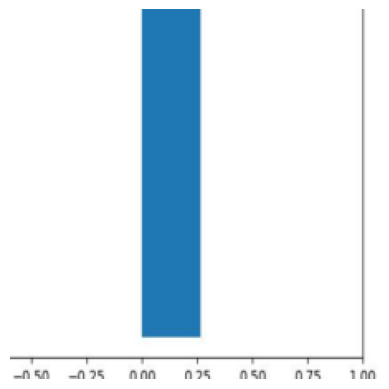

In [ ]:
data = train_crop_data[17]
show_image(data)

### Перспективное преобразование

In [ ]:
train_perspective_data = dataset_statistic(path_train, transforms=perspective_transform)
train_perspective_loader = torch.utils.data.DataLoader(train_perspective_data, batch_size=32, shuffle=True)

7


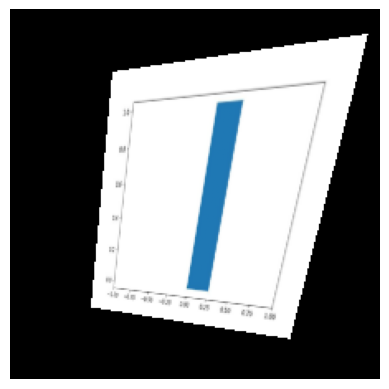

In [ ]:
data = train_perspective_data[17]
show_image(data)

### Поворот изображения

In [ ]:
train_rotate_data = dataset_statistic(path_train, transforms=rotation_transform)
train_rotate_loader = torch.utils.data.DataLoader(train_rotate_data, batch_size=32, shuffle=True)

7


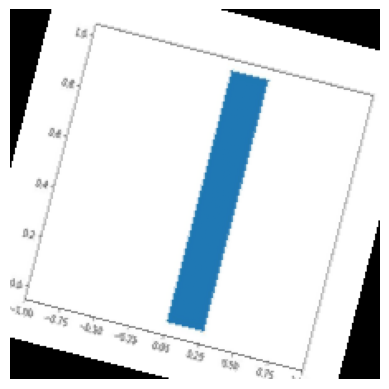

In [ ]:
data = train_rotate_data[17]
show_image(data)

### Изменение цвета изображения

In [ ]:
train_color_data = dataset_statistic(path_train, transforms=color_transform)
train_color_loader = torch.utils.data.DataLoader(train_color_data, batch_size=32, shuffle=True)

7


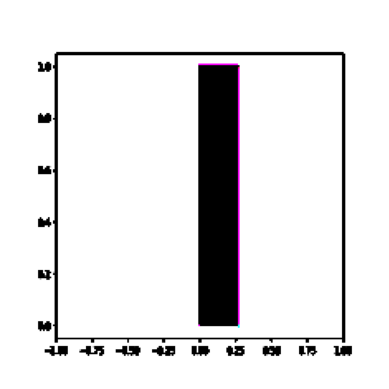

In [ ]:
data = train_color_data[17]
show_image(data)

## Модели

### Основная модель

In [ ]:
class LokiNet(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super().__init__()
        # обычно эту часть называют «тушкой модели»
        self.encoder = nn.Sequential(
            # первый свёрточный слой
            nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # экскурс: stride - шаг, с которым прикладываем ядро свёртки
            # паддинг - размер доп обрамления (чтобы учитывать края изображения при свёртке)
            # функция активации
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            # ещё одна техника, фактически проходимя матричкой 2x2 и берём максимум, делаем с шагом stride
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        # обычно называют «головой», тк это полносвязные сети, которые могут уловить больше необходимой информации
        self.head = nn.Sequential(
            # полносвязный слой
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            # dropout механизм «выкидывания» нейронов из сетки с вероятностью p
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x):
        out = self.encoder(x)
        # растягиваем матричку в вектор
        out = nn.Flatten()(out)
        out = self.head(out)
        return out

### Тестовая модель

In [ ]:
class smallNet(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes),
        )

    def forward(self, x):
        # print(x.shape)
        out = self.encoder(x)
        # print(out.shape)
        out = nn.Flatten()(out)
        # print(out.shape)
        out = self.head(out)
        return out

## Визуализация

In [ ]:
def plot_logs(train_accuracy, val_accuracy, train_losses, val_losses):
  clear_output()
  fig, axs = plt.subplots(1, 2, figsize=(13, 4))

  axs[1].plot(train_accuracy, label='train')
  points = np.array(val_accuracy)
  axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
  axs[1].set_ylabel('accuracy')

  axs[0].plot(train_losses, label='train')
  points = np.array(val_losses)
  axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
  axs[0].set_ylabel('loss')

  for ax in axs:
      ax.set_xlabel('step')
      ax.legend()

  plt.show()

## Обучение и тест

Нейросети обучают эпохами, эпоха -- это один цикл обучения модели на массиве данных

In [ ]:
def train_epoch(model, criterion, train_loader, optimizer, name):
    # режим работы модели, нужен хотя бы для dropout, тк в трейне нейроны можно выкидывать, а при предсказании трогать ничего не надо
    model.train()

    accuracy_log, loss_log = [], []
    accuracy_log_wb, loss_log_wb = 0, 0
    # images: [32, 3, 224, 224]
    # labels: [32]
    for images, labels in train_loader:
        # скидываем на gpu
        images = images.to(device)
        labels = labels.to(device)

        # обнуление градиента, тк он копится при новом взятии производной
        optimizer.zero_grad()

        # предсказываем вероятности
        logits = model(images)

        # считаем лосс
        loss = criterion(logits, labels)
        # находим производную
        loss.backward()
        # делаем шаг градиентного спуска
        optimizer.step()

        # предсказания
        labels_pred = torch.max(logits, dim=1)[1].cpu().detach().numpy()
        labels_true = labels.cpu().detach().numpy()

        # сохраняем статистику
        accuracy_log.append(np.mean(labels_pred == labels_true))
        loss_log.append(loss.item())

        # для логирования
        accuracy_log_wb += (logits.argmax(dim=1) == labels).sum().item()
        loss_log_wb += loss.item() * images.shape[0]

        # посчитали метрику по батчу и записали в лог
        metrics = {
            f"{name} batch-train loss": loss.item()
        }
        wandb.log(metrics)

    # усреднённая метрика
    accuracy_log_wb /= len(train_loader.dataset)
    loss_log_wb /= len(train_loader.dataset)

    return accuracy_log, loss_log, accuracy_log_wb, loss_log_wb

In [ ]:
def test(model, criterion, val_loader):
    # режим вычислний
    model.eval()

    accuracy_log, loss_log = [], []
    accuracy_log_wb, loss_log_wb = 0, 0
    # images: [32, 3, 224, 224]
    # labels: [32]
    for images, labels in val_loader:
        # скидываем на gpu
        images = images.to(device)
        labels = labels.to(device)

        # градиент нам тут считать не нужно, не используем при тесте
        with torch.no_grad():
            # предсказываем вероятности
            logits = model(images)
            # считаем лосс
            loss = criterion(logits, labels)

        # предсказания
        labels_pred = torch.max(logits, dim=1)[1].cpu().detach().numpy()
        labels_true = labels.cpu().detach().numpy()

        # сохраняем статистику
        accuracy_log.append(np.mean(labels_pred == labels_true))
        loss_log.append(loss.item())

        # для логирования
        loss_log_wb += loss.item() * images.shape[0]
        accuracy_log_wb += (logits.argmax(dim=1) == labels).sum().item()

    accuracy_log_wb /= len(val_loader.dataset)
    loss_log_wb /= len(val_loader.dataset)

    return accuracy_log, loss_log, accuracy_log_wb, loss_log_wb,

In [ ]:
def train(model, criterion, train_loader, val_loader, optimizer, num_epoches, batch_size, name):
    # сохраняем логи для визуализации
    train_accuracy_log, train_loss_log = [], []
    val_accuracy_log, val_loss_log = [], []

    wandb.init(
        project='test',
        name=name,
        config={
            'architecture': 'CNN',
            'dataset': 'statistic_graphs',
            'epochs': num_epoches,
            'criterion': 'CrossEntropyLoss',
            'optimizer': 'AdamW'
        }
    )

    for epoch in range(1, num_epoches + 1):
        train_accuracy, train_loss, train_accuracy_wb, train_loss_wb = train_epoch(model, criterion, train_loader, optimizer, name)
        val_accuracy, val_loss, val_accuracy_wb, val_loss_wb = test(model, criterion, val_loader)

        train_accuracy_log.extend(train_accuracy)
        train_loss_log.extend(train_loss)
        # усредняем по батчам
        steps = train_loader.dataset.__len__() / batch_size

        val_accuracy_log.append((steps * epoch, np.mean(val_accuracy)))
        val_loss_log.append((steps * epoch, np.mean(val_loss)))

        clear_output()
        plot_logs(train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log)

    info = {
        'train_acc': np.mean(train_accuracy_log),
        'test_acc': val_accuracy_log[-1],
        'train_loss': np.mean(val_loss_log),
        'test_loss': val_loss_log[-1]
    }

    metrics = {
            "train accuracy": train_accuracy_wb / len(train_loader.dataset),
            "train loss": train_loss_wb / len(train_loader.dataset),
            "val accuracy": val_accuracy_wb,
            "val loss": val_loss_wb
    }
    wandb.log(metrics)

    return info

## Тестирование модели

### базовые параметры

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb
wandb.login()

True

In [ ]:
num_epoches = 10
LR = 0.05
batch_size = 32
criterion = nn.CrossEntropyLoss()

### Обучение baseline модели

In [ ]:
baseline_model = LokiNet().to(device)
baseline_optimizer = torch.optim.AdamW(baseline_model.parameters())

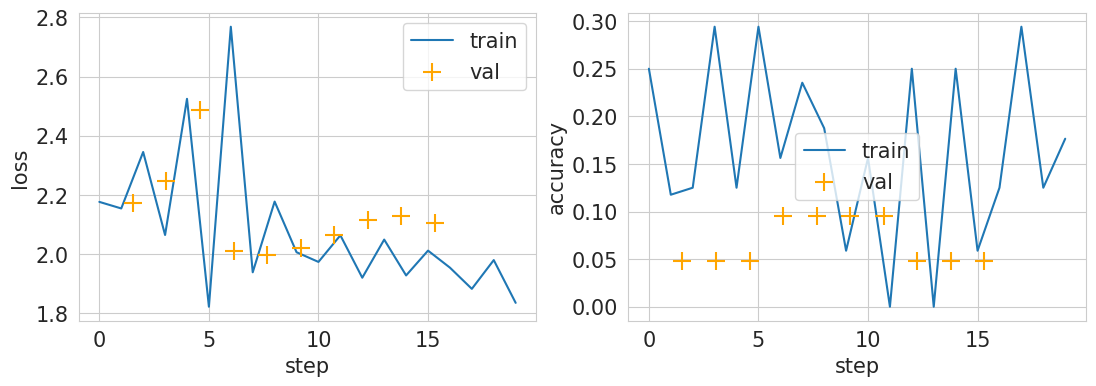

{'train_acc': 0.16397058823529412,
 'test_acc': (15.3125, 0.047619047619047616),
 'train_loss': 5.278203094005585,
 'test_loss': (15.3125, 2.1059317588806152)}

In [ ]:
train(baseline_model, criterion, train_loader, val_loader, baseline_optimizer, num_epoches, batch_size, 'baseline')

### Обучение crop модели

In [ ]:
crop_model = LokiNet().to(device)
crop_optimizer = torch.optim.AdamW(crop_model.parameters())

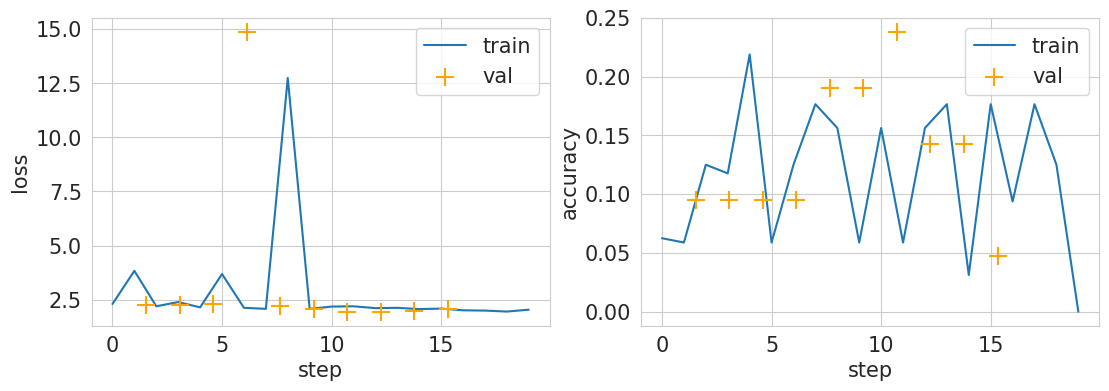

{'train_acc': 0.11544117647058824,
 'test_acc': (15.3125, 0.047619047619047616),
 'train_loss': 5.9069919526577,
 'test_loss': (15.3125, 2.0489861965179443)}

In [ ]:
train(crop_model, criterion, train_crop_loader, val_loader, crop_optimizer, num_epoches, batch_size, 'crop')

### Обучение perspective модели

In [ ]:
perspective_model = LokiNet().to(device)
perspective_optimizer = torch.optim.AdamW(perspective_model.parameters())

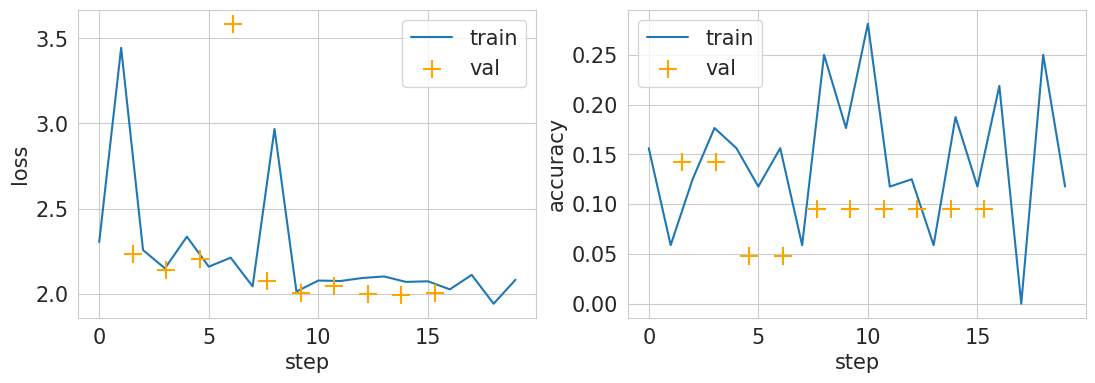

{'train_acc': 0.1453125,
 'test_acc': (15.3125, 0.09523809523809523),
 'train_loss': 5.324796259403229,
 'test_loss': (15.3125, 2.0030643939971924)}

In [ ]:
train(perspective_model, criterion, train_perspective_loader, val_loader, perspective_optimizer, num_epoches, batch_size, 'perspective')

### Обучение rotate модели

In [ ]:
rotate_model = LokiNet().to(device)
rotate_optimizer = torch.optim.AdamW(rotate_model.parameters())

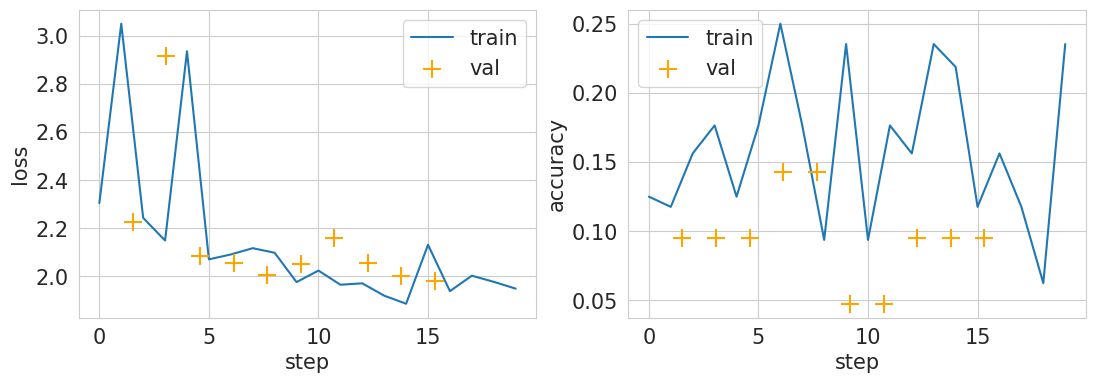

{'train_acc': 0.16011029411764707,
 'test_acc': (15.3125, 0.09523809523809523),
 'train_loss': 5.28807178735733,
 'test_loss': (15.3125, 1.9806311130523682)}

In [ ]:
train(rotate_model, criterion, train_rotate_loader, val_loader, rotate_optimizer, num_epoches, batch_size, 'rotate')

### Обучение color модели

In [ ]:
color_model = LokiNet().to(device)
color_optimizer = torch.optim.AdamW(color_model.parameters())

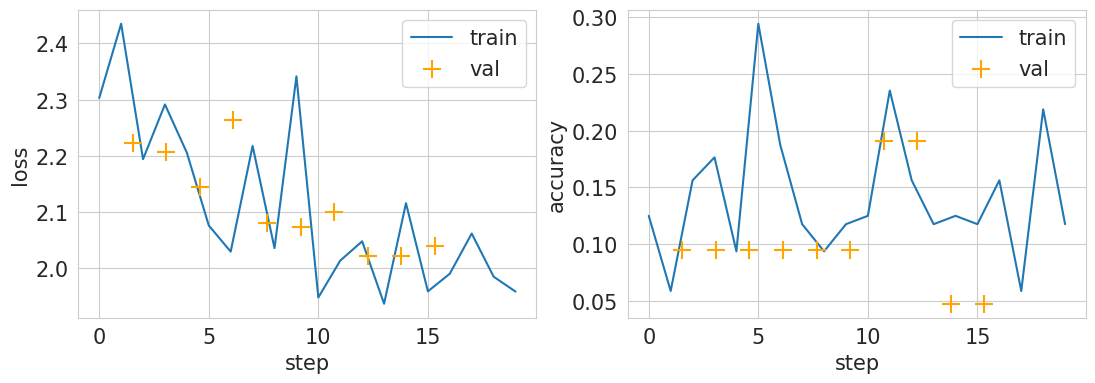

{'train_acc': 0.14246323529411764,
 'test_acc': (15.3125, 0.047619047619047616),
 'train_loss': 5.269653248786926,
 'test_loss': (15.3125, 2.0397000312805176)}

In [ ]:
train(color_model, criterion, train_color_loader, val_loader, color_optimizer, num_epoches, batch_size, 'color')

# end

In [ ]:
wandb.finish()

color batch-train loss,▆█▅▆▅▃▂▅▂▇▁▂▃▁▄▁▂▃▂▁
train accuracy,▁
train loss,▁
val accuracy,▁
val loss,▁
color batch-train loss,1.95843
train accuracy,0.00375
train loss,0.04032
val accuracy,0.04762
val loss,2.0397


# подвал

### маленький уродливый тест набросок

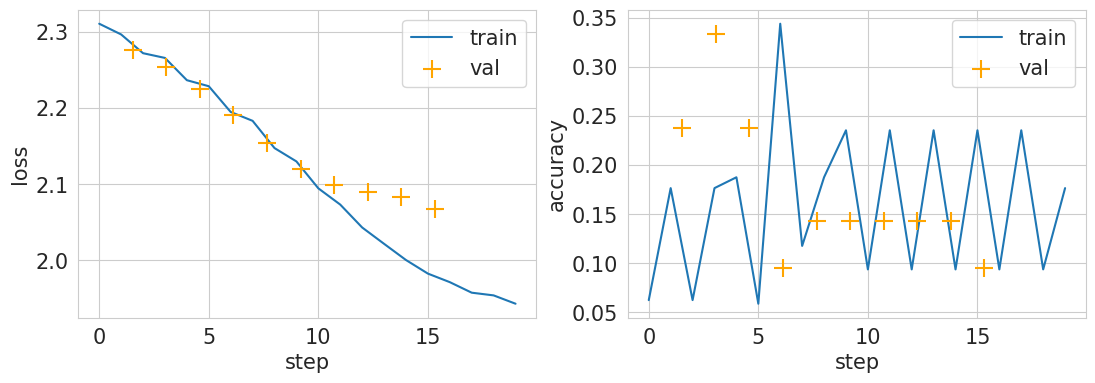

{'train_acc': 0.15974264705882352,
 'test_acc': (15.3125, 0.09523809523809523),
 'train_loss': 5.288785183429718,
 'test_loss': (15.3125, 2.066746234893799)}

In [ ]:
train_data = dataset_statistic(path_train, transforms=[T.Resize((8, 8)), T.ToTensor()])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)

val_data = dataset_statistic(path_test, transforms=[T.Resize((8, 8)), T.ToTensor()])
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)

sad_cat = smallNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(sad_cat.parameters())
train(sad_cat, criterion, train_loader, val_loader, optimizer, 10, 32)

## учусь логировать

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb
wandb.login()

True

In [ ]:
def train_epoch(model, criterion, train_loader, optimizer):
    # режим работы модели, нужен хотя бы для dropout, тк в трейне нейроны можно выкидывать, а при предсказании трогать ничего не надо
    model.train()

    accuracy_log, loss_log = 0, 0

    for num_batch, (x_batch, y_batch) in enumerate(train_loader):
        # скидываем на gpu
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # обнуление градиента, тк он копится при новом взятии производной
        optimizer.zero_grad()

        # предсказываем вероятности
        logits = model(x_batch)

        # считаем лосс
        loss = criterion(logits, y_batch)
        # находим производную
        loss.backward()
        # делаем шаг градиентного спуска
        optimizer.step()

        # сохраняем статистику
        loss_log += loss.item() * x_batch.shape[0]
        accuracy_log += (logits.argmax(dim=1) == y_batch).sum().item()

        # посчитали метрику по батчу и записали в лог
        metrics = {
            "batch-train loss": loss.item()
        }
        wandb.log(metrics)

    # усрелнённая метрика по всей эпохе
    loss_log /= len(train_loader.dataset)
    accuracy_log /= len(train_loader.dataset)

    return accuracy_log, loss_log

In [ ]:
def test(model, criterion, test_loader):
    # режим вычислний
    model.eval()

    accuracy_log, loss_log = 0, 0
    # x_batch: [32, 3, 224, 224]
    # y_batch: [32]
    for num_batch, (x_batch, y_batch) in enumerate(test_loader):
        # скидываем на gpu
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # градиент нам тут считать не нужно, не используем при тесте
        with torch.no_grad():
            # предсказываем вероятности
            logits = model(x_batch)
            # считаем лосс
            loss = criterion(logits, y_batch)

        # сохраняем статистику
        loss_log += loss.item() * x_batch.shape[0]
        accuracy_log += (logits.argmax(dim=1) == y_batch).sum().item()

    loss_log /= len(test_loader.dataset)
    accuracy_log /= len(test_loader.dataset)

    return accuracy_log, loss_log

In [ ]:
def train(model, criterion, train_loader, val_loader, optimizer, num_epoches, batch_size):
    for epoch in range(num_epoches):
        train_accuracy, train_loss = train_epoch(model, criterion, train_loader, optimizer)
        test_accuracy, test_loss = test(model, criterion, val_loader)

        metrics = {
            "train accuracy": train_accuracy / len(train_loader.dataset),
            "train loss": train_accuracy / len(train_loader.dataset),
            "val accuracy": test_accuracy,
            "val loss": test_loss,
        }
        wandb.log(metrics)